<a href="https://colab.research.google.com/github/domshog/Projects/blob/master/Walmart_Store_Sales_Forecasting_DONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA

In [ ]:
#!curl -O  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3816/32105/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1655854441&Signature=NuFvNHjUEM5TTW2PZ2Aacq5eFnO0y%2BY9LcMyt4wp9knSxQzhyUxDHJ9ZAuYx9pTUU5MJRV8okRo0IHFJdVXq2l1UR10s4vpMJ%2BwTJBJBD1tfHqH6jbGUkgLTYHzCGLGDCpduT3x9P0TzJznERaaxfBLUQR9LRciQKvwafbWYvtScl1r6V2ah%2FQmYBsnZm6W%2BLu4PiHOOBCy%2BRR1IY18o83%2F0HRq3aOPzrlYjuASWWI3cVrMGky6kKcw90S2IOwF9ZshHp56tHB5ZoHRdNrXJ%2BqchwcbOsEElffeJ6S%2FHxQl3QP8rBR7a9VsI%2BLZoY8d3gJWXdAxftZ90PEuGALq%2FHQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dwalmart-recruiting-store-sales-forecasting.zip

In [1]:
!unzip -q walmart-recruiting-store-sales-forecasting.zip
!ls

replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 'archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com'
 features.csv
 features.csv.zip
 sample_data
 sampleSubmission.csv.zip
 stores.csv
 test.csv
 test.csv.zip
 train.csv
 train.csv.zip
 walmart-recruiting-store-sales-forecasting.zip


In [2]:
!unzip -q stores.csv.zip
!unzip -q train.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip
!ls

replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: features.csv		  test.csv
features.csv.zip	  test.csv.zip
sample_data		  train.csv
sampleSubmission.csv.zip  train.csv.zip
stores.csv		  walmart-recruiting-store-sales-forecasting.zip


# First CODE

In [ ]:
pip install pandasql

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [44]:
features = pd.read_csv("features.csv")
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv('sampleSubmission.csv.zip')

## 2-Exploratory Analysis and Data Cleaning

In [45]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [46]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [47]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [48]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [49]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [50]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [51]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year


In [52]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [53]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [54]:
del features, train, stores, test

In [55]:
# At this point, we can search for null values for each column.


null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


This is important, there are columns with more than 60% of null values. If the correlations of these features with the target 'WeeklySales' are ~0, then it is not a good idea to use them. Also, they are anonymized fields, it can be difficult to know what they mean.



## Holidays Analysis

Here, we will analyze the week days that the Holidays fall on each year. This is relevant to know how many pre-holiday days are inside each Week marked as 'True' inside 'IsHoliday' field.

If, for a certain Week, there are more pre-holiday days in one Year than another, then it is very possible that the Year with more pre-holiday days will have greater Sales for the same Week. So, the model will not take this consideration and we might need to adjust the predicted values at the end.

Another thing to take into account is that Holiday Weeks but with few or no pre-holiday days might have lower Sales than the Week before.

We can use SQL, putting the week days for each Holiday in every year. Doing some research, the Super Bowl, Labor Day and Thanksgiving fall on the same day. In the other hand, Christmas is always on December 25th, so the week day can change.

In [ ]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

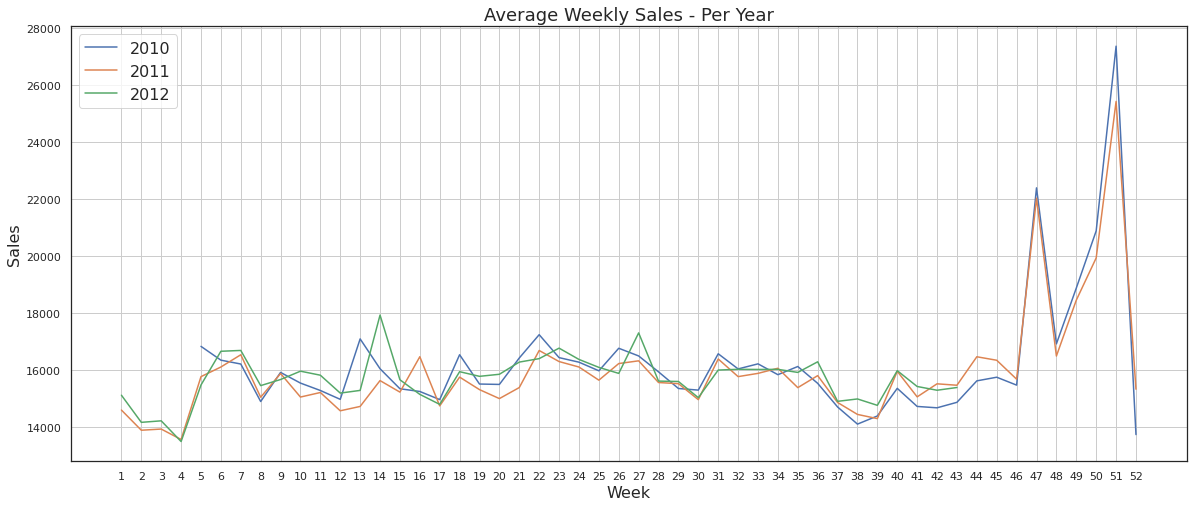

In [57]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.

In 2010 is in Week 13

In 2011, Week 16

Week 14 in 2012

and, finally, Week 13 in 2013 for Test set

So, we can change to 'True' these Weeks in each Year.

In [58]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

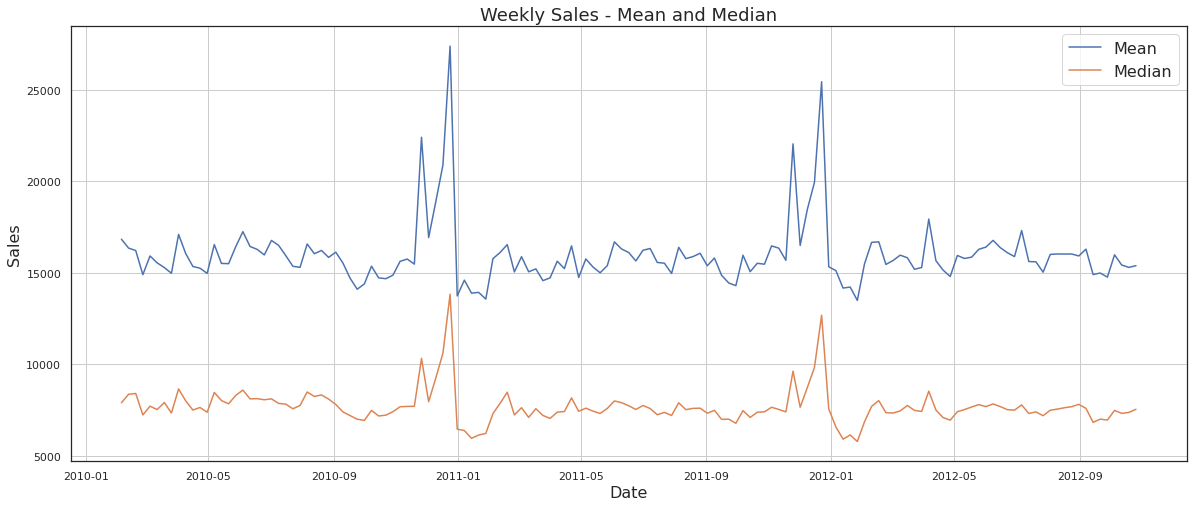

In [59]:
#The same chart, but showing also the median of the Sales and not divided by Year:

weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

## Average Sales per Store and Department

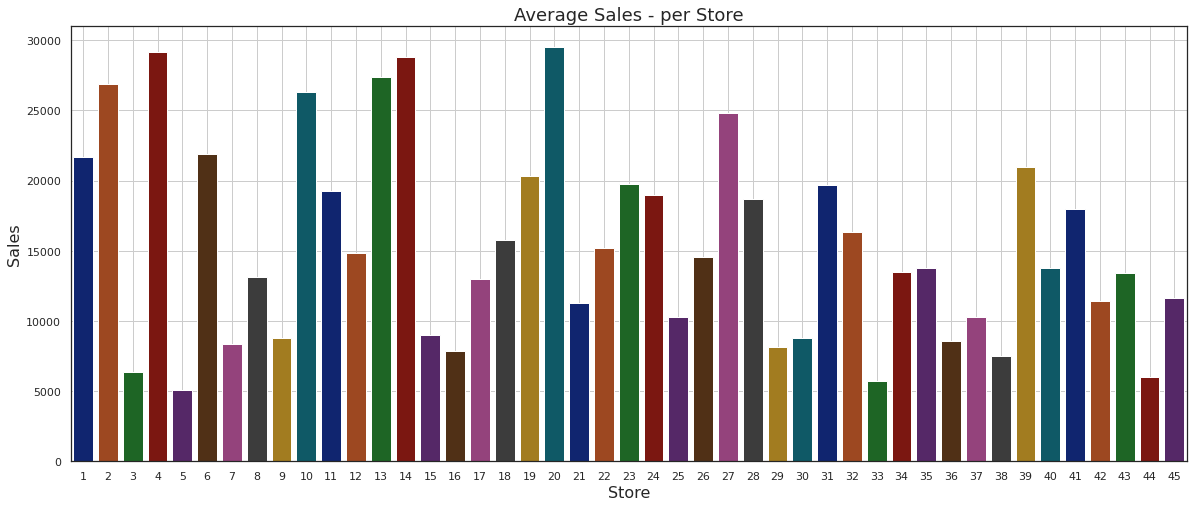

In [60]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

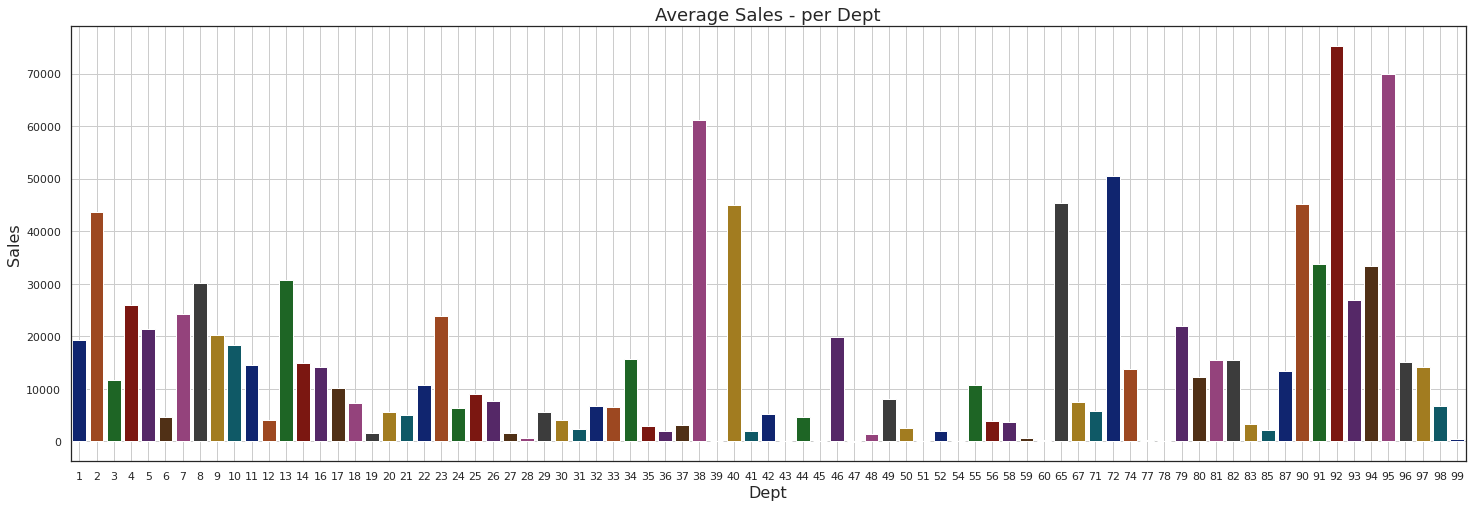

In [61]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

## Variables Correlation

Correlation Metrics:

0: no correlation at all

0-0.3: weak correlation

0.3-0.7: moderate correlaton

0.7-1: strong correlation

Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.

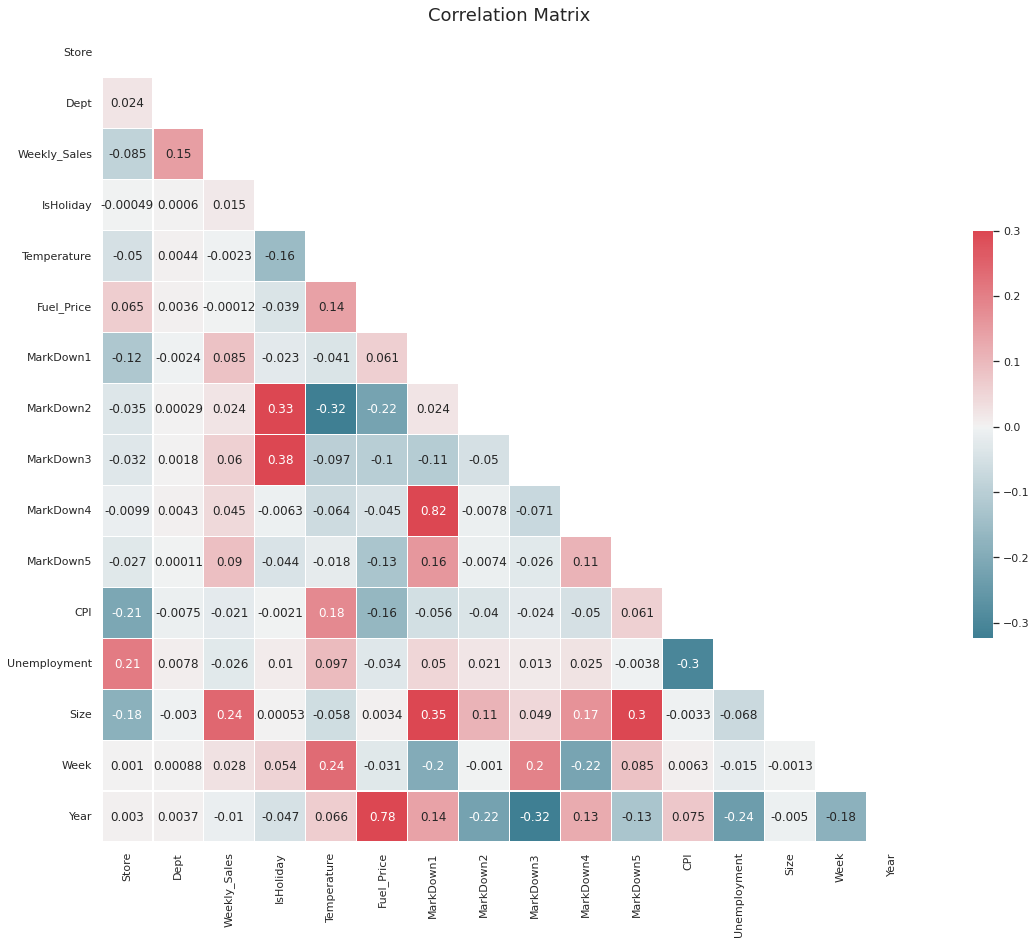

In [62]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

'MarkDown' 1 to 5 are not strong correlated to 'Weekly_Sales' and they have a lot of null values, then we can drop them.

Also, 'Fuel_Price' is strong correlated to 'Year'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

Other variables that have weak correlation with 'Weekly_Sales' can be analyzed to see if they are useful.

In [63]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

## Analyzing Variables

First, two plot functions that will help us.

The discrete plot is for finite numbers. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

The continuous plot, as the name says, is for continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.

In [64]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [65]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

## Weekly_Sales x IsHoliday

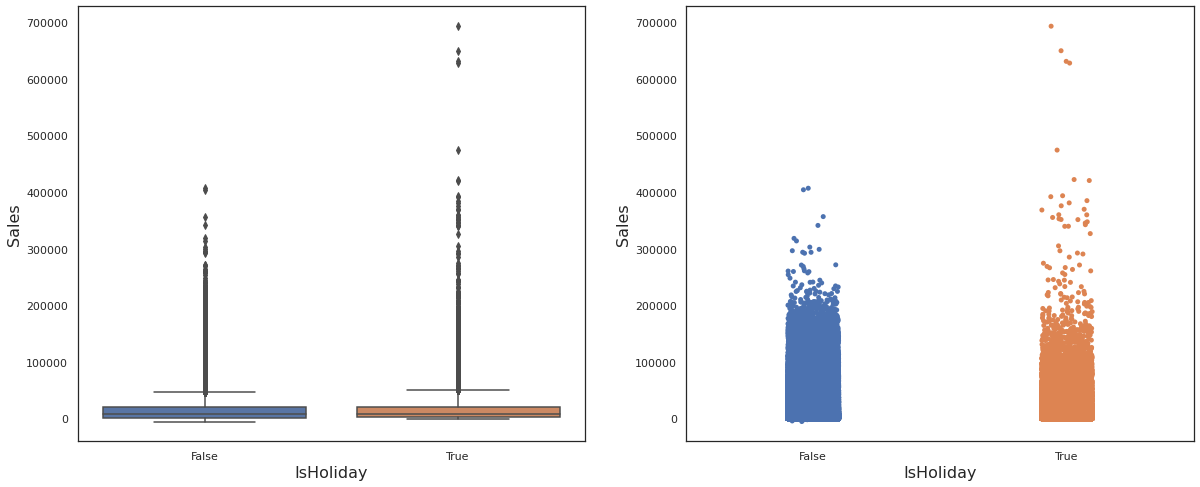

In [66]:
make_discrete_plot('IsHoliday')

This field is going to be important to differentiate Week Holidays. As we can see, Week Holidays have more high sales events than non-Holiday Weeks.

## Weekly_Sales x Type

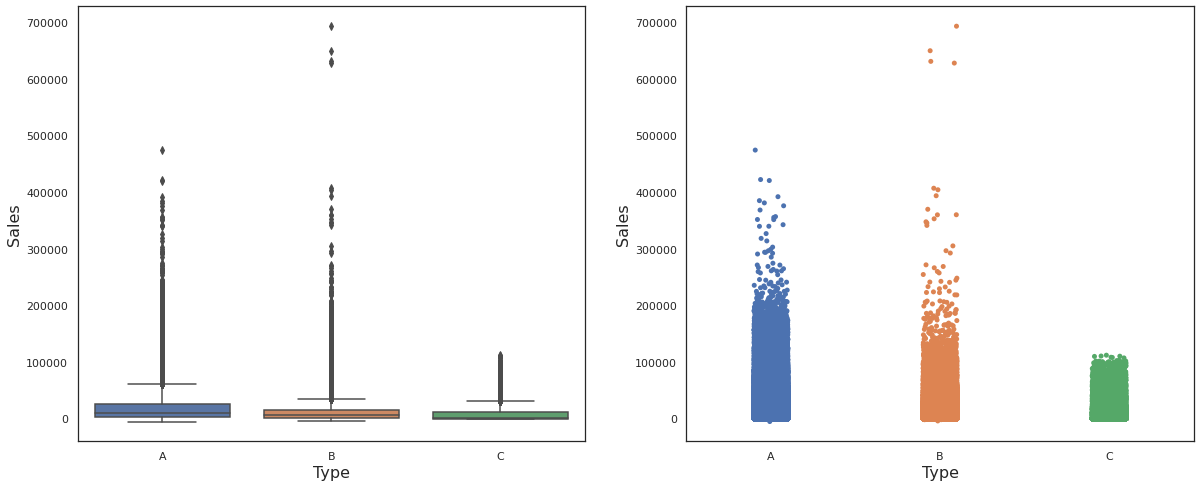

In [67]:
make_discrete_plot('Type')

We don't know what 'Type' is, but we can assume that A > B > C in terms of Sales Median. So, let's treat it as an ordinal variable and replace its values.

Ordinal variables are explained in the figure below.

In [68]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

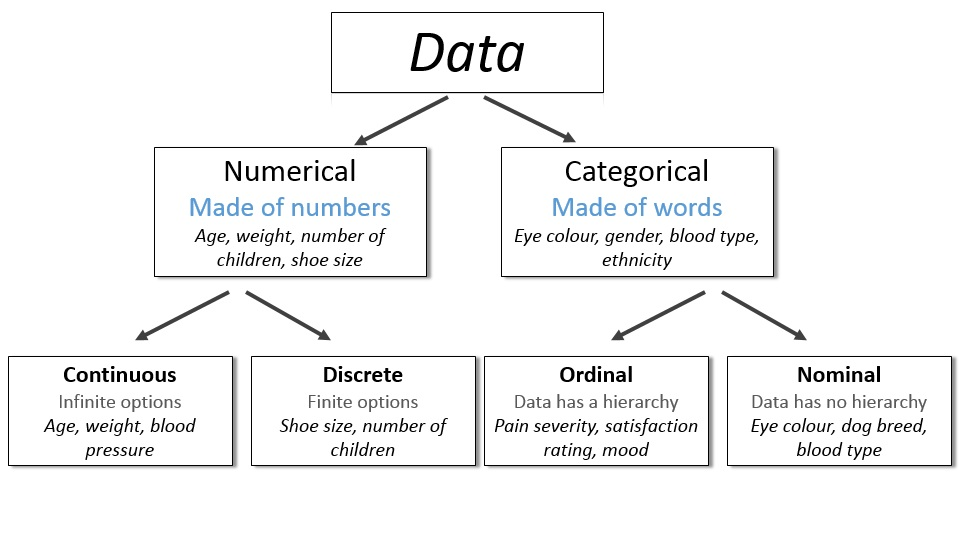

## Weekly_Sales x Temperature

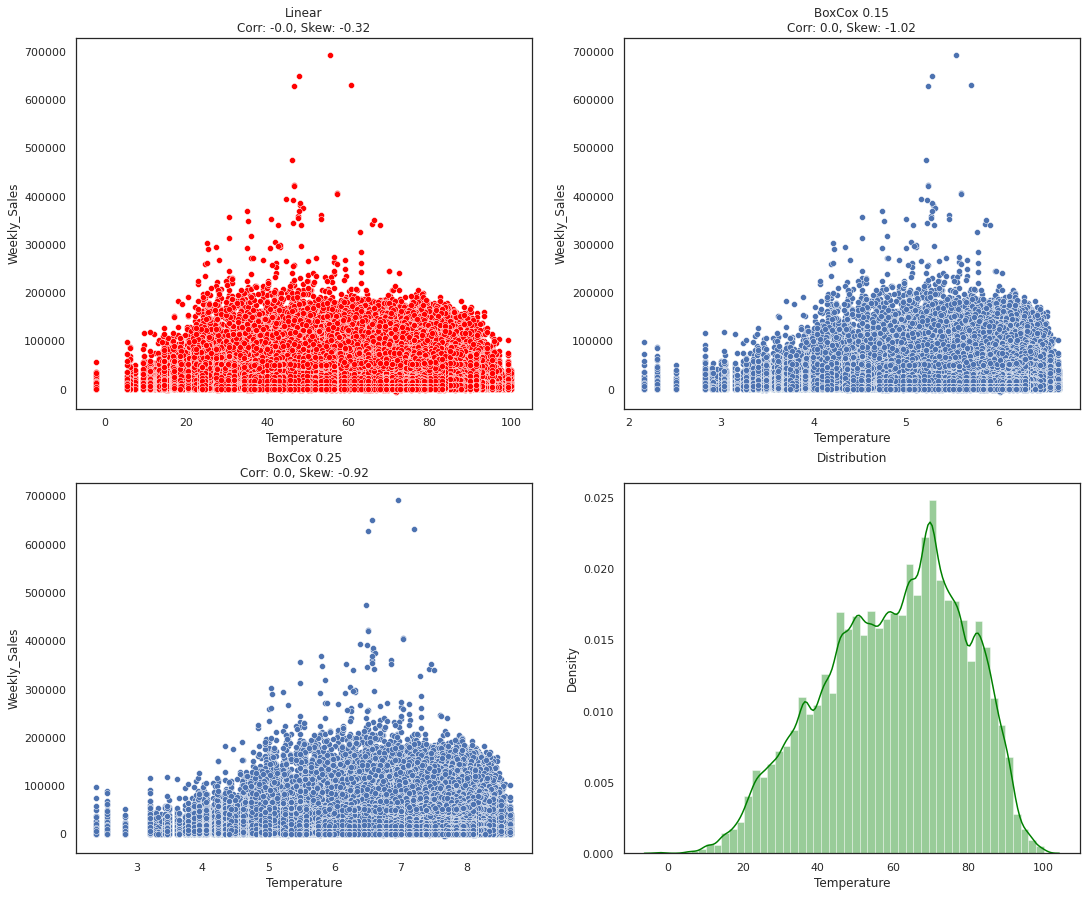

In [69]:
make_continuous_plot('Temperature')

Although skewness changes, correlation doesn't seem to change at all. We can decide to drop it.

In [70]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

## Weekly_Sales x CPI

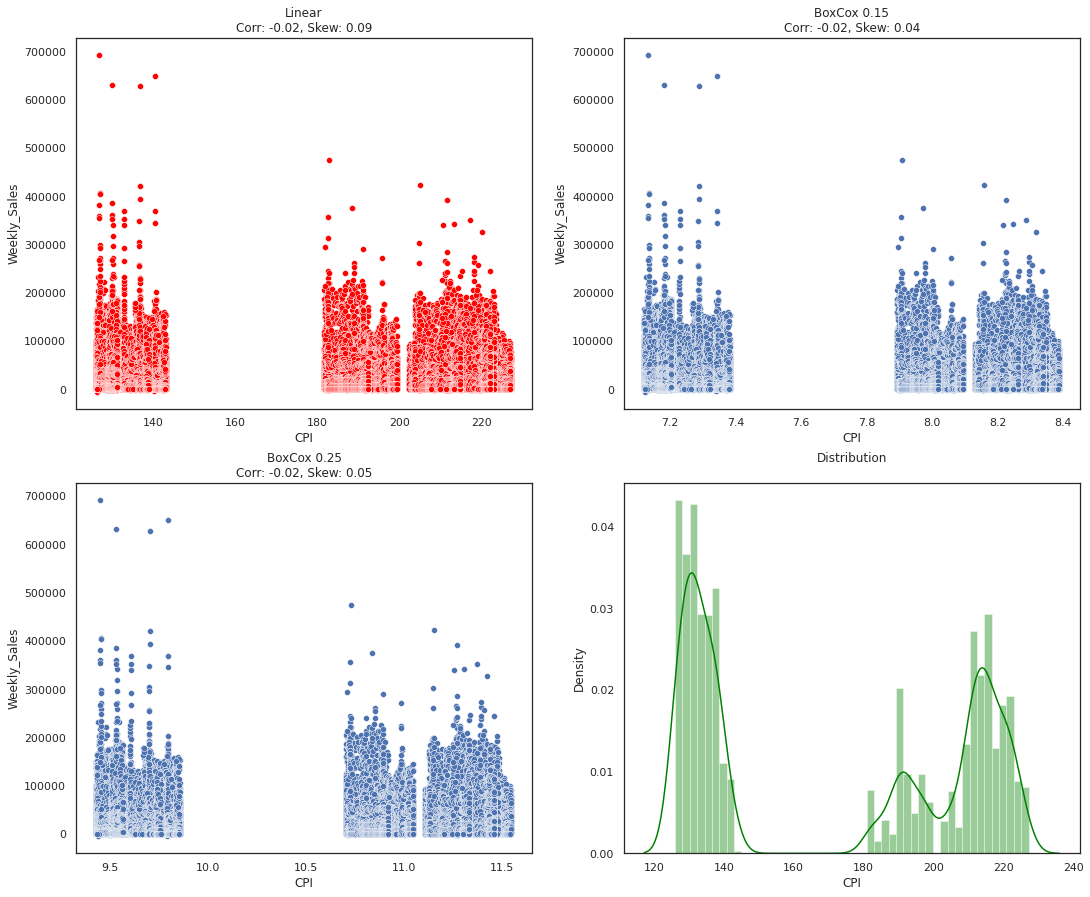

In [71]:
make_continuous_plot('CPI')

Same for 'CPI'.

In [72]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

## Weekly_Sales x Unemployment

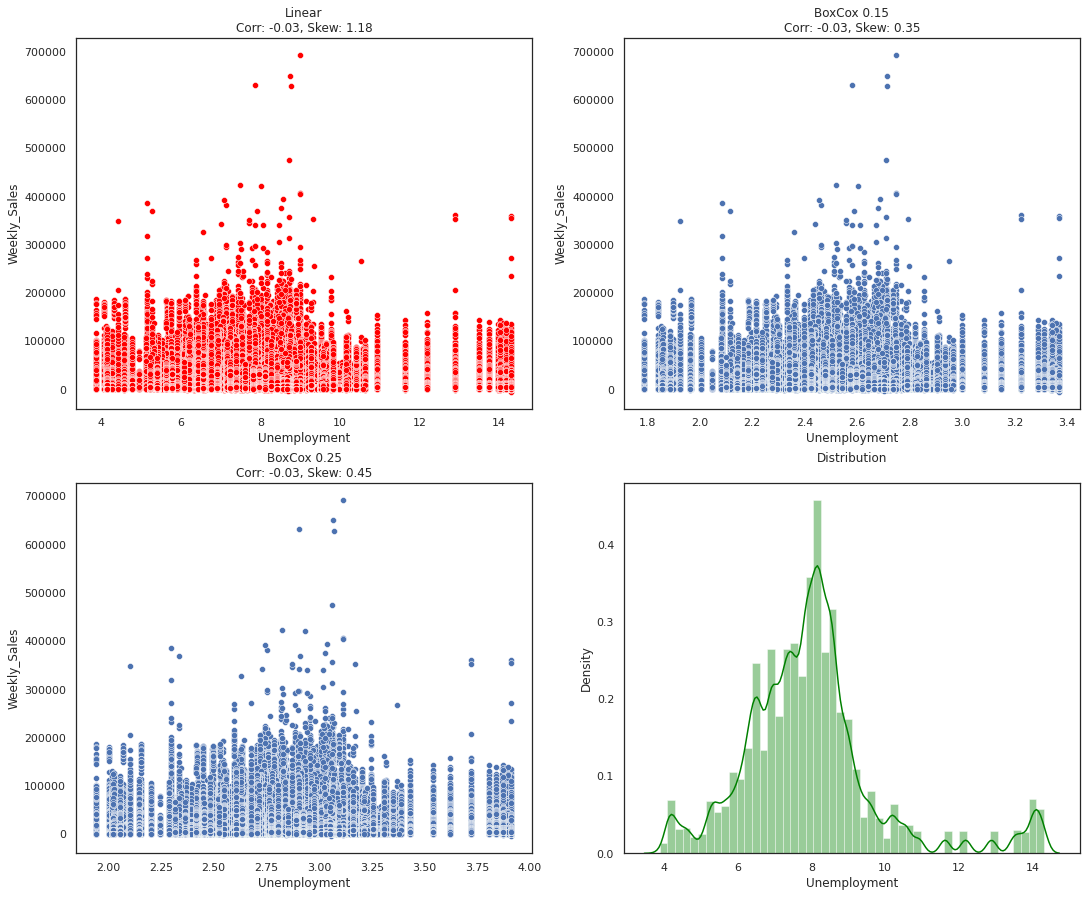

In [73]:
make_continuous_plot('Unemployment')

Same for 'Unemployment' rate.

In [74]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

## Weekly_Sales x Size

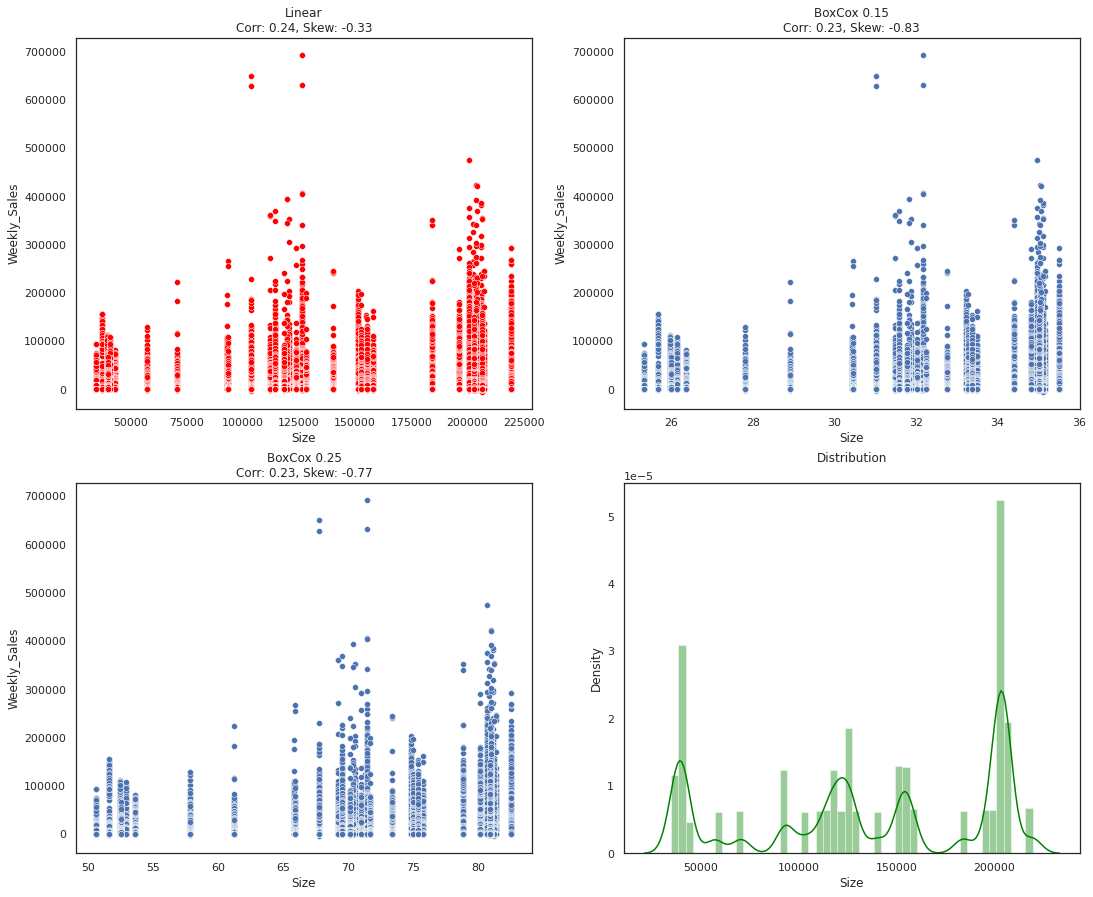

In [75]:
make_continuous_plot('Size')

And, finally, we will continue with this variable, since it has moderate correlation with 'WeeklySales'.

# 3- Predicting model


The functions for Random Forest, Parameters Tuning and Cross Validation are:

In [76]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [77]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [78]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [79]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

# Training Model

In [80]:
# Preparing Train Set.

X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

In [81]:
# Tuning 'n_estimators' and 'max_depth'.
# Here, it is possible to test a lot of values. Those are the final ones, after a bit of testing.

n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1536.5700000000002
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1538.3675
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1549.415
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1524.1
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1552.1125
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth

,Max_Depth,Estimators,WMAE
0,25,56,1536.5700
1,27,56,1538.3675
2,30,56,1549.4150
3,25,58,1524.1000
4,27,58,1552.1125
5,30,58,1537.1600
6,25,60,1539.5175
7,27,60,1537.0175
8,30,60,1546.3400


In [82]:
# Tuning 'max_features'.

max_features = [2, 3, 4, 5, 6, 7]
random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4593.855
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2675.085
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1782.6000000000001
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1571.7525
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1539.5225
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1541.81


,Max_Feature,WMAE
0,2,4593.8550
1,3,2675.0850
2,4,1782.6000
3,5,1571.7525
4,6,1539.5225
5,7,1541.8100


In [83]:
# Tuning 'min_samples_split' and 'min_samples_leaf'.

min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1546.8125000000002
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1597.9175
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1632.9225
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1516.4375
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_split: 3

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1546.8125
1,2,2,1597.9175
2,3,2,1632.9225
3,1,3,1516.4375
4,2,3,1619.1550
5,3,3,1637.2550
6,1,4,1552.1400
7,2,4,1590.2225
8,3,4,1634.2650


In [84]:
# The final model:

RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

# Prediction

In [92]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

In [95]:
print (predict)

[31445.59882759 19865.25886207 19615.13644828 ...   689.29546839
   751.35389943   687.79681034]


# Christmas Adjustment

Ok, now it's time to make the Christmas Adjustment.

We can remember that Christmas Week has 0 pre-holiday days in 2010, 1 in 2011 and 3 in 2012. So, it's a difference of 3 days from 2012 to 2010 and 2 days from 2012 to 2011. A 2.5 days average, in a week (7 days). So, this is the value that we are going to multiply to Week 51 and add to Week 52 to compensate what the model didn't take into account.

But we are going to use this formula just for 'Stores'+'Departments' that have a big difference between Week 51 and Week 52 Sales. Let's say Week51 > 2 * Week52.

Let's use another dataframe and SQL to solve it quickly.

In [89]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [91]:
print (predict)

[31445.59882759 19865.25886207 19615.13644828 ...   689.29546839
   751.35389943   687.79681034]


In [ ]:
Final_adj = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")